In [1]:
#Waste Classification

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Assign dataset images to variables
train_o ='C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TRAIN/O'
train_r ='C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TRAIN/R'
val_o = 'C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TEST/O'
val_r = 'C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TEST/R'


In [3]:
train_dir = 'C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TRAIN'
test_dir = 'C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TEST'

def load_dataset(path):
    data = load_files(path) #load all files from the path
    #print(data)
    files = np.array(data['filenames']) #get the file, All images addresses in an array
    #print(files)
    targets = np.array(data['target'])#get the the classification labels as integer index
    #print(targets[:12]) #0 for Organic and 1 for Recyclable
    target_labels = np.array(data['target_names'])#get the the classification labels 
    print(target_labels) #Target labels are O or R
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)

#Now we know how to load images as array:>

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

['O' 'R']
['O' 'R']
Training set size :  22564
Testing set size :  2512


(-0.5, 224.5, 224.5, -0.5)

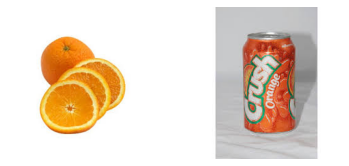

In [23]:
import matplotlib.image as mpimg

img1 = mpimg.imread('C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TRAIN/O/O_14.jpg')
img2 = mpimg.imread('C:/Users/arvin/OneDrive/Desktop/Completed Projects/NLP2SQL/DATASET/DATASET/TRAIN/R/R_2109.jpg')
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2)
plt.axis('off')

In [24]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)


In [25]:
print("x_train shape: " + str(x_train.shape))
print("x_train shape: " + str(y_train.shape))
print("x_validate shape: " + str(x_validate.shape))
print("y_validate shape: " + str(y_validate.shape))
print("x_test shape: " + str(x_test.shape))
print("y_test shape: " + str(y_test.shape))

x_train shape: (14440,)
x_train shape: (14440,)
x_validate shape: (3611,)
y_validate shape: (3611,)
x_test shape: (2512,)
y_test shape: (2512,)


In [26]:
#We need to convert jpg file to numpy array to feed to the CNN.
#Opencv library is used to perform this task.

def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC) #As images have different size, resizing all images to have same shape of image array
        images_as_array[idx] = res
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_validate))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Training set shape :  (14440, 100, 100, 3)
Validation set shape :  (3611, 100, 100, 3)
Test set shape :  (2512, 100, 100, 3)


In [27]:
x_train = x_train.astype('float32')/255
#print(x_train)
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_validate = y_validate.reshape(y_validate.shape[0],1)

In [29]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)


In [30]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3, 3),kernel_initializer='he_uniform',activation='relu',input_shape=(100,100,3),name = 'conv0'))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', name = 'conv1'))
model.add(BatchNormalization(name='bn0'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool0'))
model.add(Dropout(0.2,name='dropout0'))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name = 'conv2'))
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', name = 'conv3'))
model.add(BatchNormalization(name='bn1'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool1'))
model.add(Dropout(0.2,name='dropout1'))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',name = 'conv4'))
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',name = 'conv5'))
model.add(BatchNormalization(name='bn2'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool2'))
model.add(Dropout(0.3,name='dropout2'))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',name = 'conv6'))
model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',name = 'conv7'))
model.add(BatchNormalization(name='bn3'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool3'))
model.add(Dropout(0.3,name='dropout3'))

model.add(Flatten(name='fc'))
model.add(Dense(512, activation='relu',name = 'Dense0'))
model.add(Dense(256, activation='relu',name = 'Dense1'))
model.add(Dense(128, activation='relu',name = 'Dense2'))
model.add(Dropout(0.3,name='dropout4'))
model.add(Dense(2, activation='softmax',name = 'Dense3'))

model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [31]:
checkpoint = ModelCheckpoint(filepath = 'cnn.hdf5', verbose = 1, save_best_only = True)


In [32]:
earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 5, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

In [33]:
ReduceLR = ReduceLROnPlateau(patience=3, verbose=1)


In [34]:
callbacks = [earlystop, checkpoint, ReduceLR]


In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 20), epochs = 20, verbose=1,callbacks = callbacks,validation_data=(x_valid,y_validate))


Epoch 1/20
722/722 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.5880
Epoch 00001: val_loss improved from 0.49032 to 0.38932, saving model to cnn.hdf5
722/722 [==============================] - 688s 953ms/step - loss: 0.4487 - accuracy: 0.5880 - val_loss: 0.3893 - val_accuracy: 0.5367
Epoch 2/20
415/722 [================>.............] - ETA: 4:39 - loss: 0.4265 - accuracy: 0.5665

In [ ]:
import pickle

pickle_out = open("Trained_cnn_history.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("Trained_cnn_history.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()


In [ ]:
model = load_model('cnn.hdf5')
model.load_weights('cnn.hdf5')

In [ ]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(x_test)


In [ ]:
confusion_mtx = confusion_matrix(y_test, predicted_classes) 

plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['R','O'], rotation=90)
plt.yticks(tick_marks, ['R','O'])
#Following is to mention the predicated numbers in the plot and highligh the numbers the most predicted number for particular label
thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j],
    horizontalalignment="center",
    color="white" if confusion_mtx[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
